# Topic Modeling for Patent data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
import sys
import re, numpy as np, pandas as pd

In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [6]:
patent=pd.read_csv('patent_all_en_new.csv')

# Working with main text variable

In [7]:
patent_abst=patent['appln_abstr']

In [8]:
patent_abst[:5]

0    An electrical energy system including an elect...
1    An electrical energy system including an elect...
2    An object is to provide a particulate trap for...
3    PURPOSE: To obtain a trap by which the leakage...
4    A particulate trap for a diesel engine designe...
Name: appln_abstr, dtype: object

In [9]:
patent_abst[2]

'An object is to provide a particulate trap for a diesel engine which can efficiently burn particulates trapped by a filter while supplying oxygen by natural convection so that the filter can be regenerated in a short time while minimizing the power consumed by the heater. To accomplish this purpose, end plates 6, 7 and brackets 9 may be welded to compressed portions 4a, 5a of an inner cylinder 4 and an outer cylinder 5; heater-supporting ceramic insulators are mounted, spaced from each other, on a heater 14; and/or an ambient air introducing passage 36 is provided to extend from outside the case into a multiple-cylinder filter provided in the case. <IMAGE>'

# Checking duplicate values in abstract column

In [77]:
#patent.appln_abstr.duplicated()
patent_abst.duplicated()

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
68734    False
68735    False
68736    False
68737    False
68738    False
68739    False
68740    False
68741    False
68742    False
68743    False
68744    False
68745    False
68746    False
68747    False
68748    False
68749    False
68750    False
68751    False
68752    False
68753    False
68754    False
68755     True
68756    False
68757    False
68758     True
68759    False
68760    False
68761    False
68762    False
68763    False
Name: appln_abstr, Length: 68764, dtype: bool

In [78]:
patent_abst.duplicated().sum()

8439

In [79]:
#patent.loc[patent.appln_abstr.duplicated
patent_abst.loc[patent_abst.duplicated()]

81       An IC engine fuel supply system (10) having a vapourisation chamber (30) which has a foam mantle...
82       An IC engine fuel supply system (10) having a vapourisation chamber (30) which has a foam mantle...
85       A method of controlling the idle speed of an engine of a vehicle. In the case of a vehicle havin...
96       A method of controlling the engine speed of an internal combustion engine, the method including ...
98       A method for the release of energy in storage hydraulic energy propulsion systems having hydro-p...
103      A method for the thermal management of a fuel cell, which method comprises: processing a fuel su...
104      A method for the thermal management of a fuel cell, which method comprises: processing a fuel su...
144      An energy distribution network for providing hydrogen fuel to a user comprising; energy source m...
147      An energy distribution network for providing hydrogen fuel to a user comprising; energy source m...
148      An energy 

In [ ]:
# mark duplicates as true except 1st occurance.So, all 1st values are keep and all others are identified as duplicates.
#We can change as 'last'
patent.loc[patent.appln_abstr.duplicated(keep= False), :]

### checking missing value for text i.e abstract and title

In [85]:
patent.duplicated(subset=['appln_abstr','appln_title']).sum()

3420

Clearly, there is a decrease from 8439 when we only used abstract to 3420 when we added title as well.

In [86]:
patent.duplicated(subset=['appln_abstr','appln']).sum()

0

In [87]:
patent.duplicated(subset=['appln_title','appln']).sum()

0

### To drop duplicate values

patent.appln_abstr.drop_duplicates(keep='first')<br>
patent.shape

If we want to drop duplicate values from both abstract and title then

patent.drop_duplicates(subset=['appln_abstr','appln_title']) <br>
patent.shape

# 1)- Data Preprocessing and cleaning

### 1.1)-Tokenize Sentences and Clean

In [10]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove extra characters
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 

In [11]:
# Convert to list
data = patent.appln_abstr.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['an', 'electrical', 'energy', 'system', 'including', 'an', 'electric', 'utility', 'having', 'electricity', 'generation', 'apparatus', 'and', 'distribution', 'lines', 'plurality', 'of', 'electric', 'vehicles', 'and', 'electric', 'power', 'storage', 'apparatus', 'receiving', 'electrical', 'power', 'from', 'the', 'electric', 'utility', 'and', 'supplying', 'electrical', 'power', 'to', 'the', 'plurality', 'of', 'electric', 'vehicles', 'and', 'to', 'the', 'electric', 'utility', 'when', 'required', 'discharged', 'slurry', 'is', 'received', 'at', 'discharged', 'slurry', 'storage', 'facility', 'from', 'the', 'electric', 'vehicles', 'and', 'storage', 'battery', 'and', 'supplied', 'to', 'electrolytic', 'cells', 'via', 'suitable', 'pumps', 'the', 'charged', 'slurry', 'is', 'received', 'in', 'facility', 'and', 'then', 'stored', 'in', 'storage', 'battery', 'or', 'supplied', 'to', 'electric', 'vehicles', 'the', 'storage', 'battery', 'provides', 'when', 'necessary', 'or', 'economical', 'electrical',

In [12]:
print(data_words[2])

['an', 'object', 'is', 'to', 'provide', 'particulate', 'trap', 'for', 'diesel', 'engine', 'which', 'can', 'efficiently', 'burn', 'particulates', 'trapped', 'by', 'filter', 'while', 'supplying', 'oxygen', 'by', 'natural', 'convection', 'so', 'that', 'the', 'filter', 'can', 'be', 'regenerated', 'in', 'short', 'time', 'while', 'minimizing', 'the', 'power', 'consumed', 'by', 'the', 'heater', 'to', 'accomplish', 'this', 'purpose', 'end', 'plates', 'and', 'brackets', 'may', 'be', 'welded', 'to', 'compressed', 'portions', 'of', 'an', 'inner', 'cylinder', 'and', 'an', 'outer', 'cylinder', 'heater', 'supporting', 'ceramic', 'insulators', 'are', 'mounted', 'spaced', 'from', 'each', 'other', 'on', 'heater', 'and', 'or', 'an', 'ambient', 'air', 'introducing', 'passage', 'is', 'provided', 'to', 'extend', 'from', 'outside', 'the', 'case', 'into', 'multiple', 'cylinder', 'filter', 'provided', 'in', 'the', 'case', 'image']


### 1.2)-Build the Bigram, Trigram Models,Postag and Lemmatize
postage : NOUN', 'ADJ', 'VERB', 'ADV

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [14]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [15]:
df_data_ready = pd.DataFrame(data_ready)

In [16]:
df_data_ready.head()

,0,1,2,3,4,5,6,7,8,9,...,802,803,804,805,806,807,808,809,810,811
0,electrical,energy,system,include,electric,utility,electricity,generation,apparatus,distribution,...,None,None,None,None,None,None,None,None,None,None
1,electrical,energy,system,include,electric,utility,electricity,generate,apparatus,distribution,...,None,None,None,None,None,None,None,None,None,None
2,object,provide,particulate,trap,diesel,engine,efficiently,burn,particulate,trap,...,None,None,None,None,None,None,None,None,None,None
3,purpose,obtain,trap,leakage,exhaust,gas,portion,filter,part,surely,...,None,None,None,None,None,None,None,None,None,None
4,particulate,trap,diesel,engine,design,efficiently,burn,particulate,collect,filter,...,None,None,None,None,None,None,None,None,None,None


In [17]:
df_data_ready.shape

(68764, 812)

In [18]:
import pickle

In [19]:
df_data_ready.to_pickle('data_ready.pkl')

# 2)-Build the Topic Model

### 2.1)- Create Dictionary

In [20]:
#bag of words
id2word = corpora.Dictionary(data_ready)

In [21]:
print(len(id2word))

25261


In [22]:
count = 0
for k, v in id2word.iteritems():
    print(k, v, id2word.dfs[k])
    count += 1
    if count > 10:
        break

0 activity 195
1 apparatus 5573
2 battery 13783
3 cell 6581
4 charge 11881
5 combination 816
6 conversion 1219
7 demand 1697
8 discharge 4847
9 disparate 1
10 distribution 1510


Filter out tokens that appear in
- less than 15 documents (absolute number) or
- more than 0.5 documents (fraction of total corpus size, not absolute number).
- after the above two steps, keep only the first 4000 most frequent tokens.

In [23]:
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=4000)

In [24]:
print(len(id2word))

4000


In [25]:
print (id2word[3])

cell


id2word is a dictionary that contains words. All of our data word.

### 2.2)-Create Corpus: Term Document Frequency

In [26]:
corpus = [id2word.doc2bow(text) for text in data_ready]
corpus[500]

[(19, 1),
 (20, 1),
 (22, 1),
 (39, 2),
 (41, 1),
 (128, 1),
 (145, 1),
 (177, 1),
 (193, 1),
 (251, 1),
 (271, 1),
 (277, 1),
 (286, 1),
 (296, 1),
 (311, 1),
 (351, 1),
 (353, 1),
 (360, 1),
 (370, 2),
 (372, 1),
 (374, 2),
 (376, 1),
 (379, 2),
 (382, 1),
 (392, 1),
 (393, 1),
 (402, 7),
 (403, 1),
 (404, 3),
 (409, 1),
 (429, 1),
 (443, 1),
 (465, 1),
 (482, 2),
 (498, 1),
 (513, 1),
 (521, 1),
 (542, 1),
 (550, 1),
 (615, 1),
 (629, 1),
 (648, 1),
 (650, 1),
 (688, 1),
 (716, 1),
 (718, 1),
 (750, 1),
 (867, 1),
 (1023, 1),
 (1046, 1),
 (1121, 1),
 (1123, 1),
 (1132, 1),
 (1201, 1),
 (1211, 1),
 (1212, 1),
 (2124, 1),
 (2275, 3),
 (2326, 1),
 (2327, 1)]

In [27]:
print(len(corpus))

68764


In [28]:
bow_doc_500 = corpus[500]

for i in range(len(bow_doc_500)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_500[i][0], 
                                                     id2word[bow_doc_500[i][0]], 
                                                     bow_doc_500[i][1]))

Word 19 ("include") appears 1 time.
Word 20 ("low") appears 1 time.
Word 22 ("operation") appears 1 time.
Word 39 ("system") appears 2 time.
Word 41 ("unit") appears 1 time.
Word 128 ("design") appears 1 time.
Word 145 ("assembly") appears 1 time.
Word 177 ("open") appears 1 time.
Word 193 ("small") appears 1 time.
Word 251 ("component") appears 1 time.
Word 271 ("position") appears 1 time.
Word 277 ("set") appears 1 time.
Word 286 ("connect") appears 1 time.
Word 296 ("attain") appears 1 time.
Word 311 ("arrange") appears 1 time.
Word 351 ("compact") appears 1 time.
Word 353 ("essentially") appears 1 time.
Word 360 ("rotation") appears 1 time.
Word 370 ("oil") appears 2 time.
Word 372 ("relative") appears 1 time.
Word 374 ("seal") appears 2 time.
Word 376 ("work") appears 1 time.
Word 379 ("clutch") appears 2 time.
Word 382 ("drive") appears 1 time.
Word 392 ("shaft") appears 1 time.
Word 393 ("speed") appears 1 time.
Word 402 ("gear") appears 7 time.
Word 403 ("gearbox") appears 1 ti

**From here, we can also make TF-IDF**

In [29]:
from gensim import corpora, models

tfidf = models.TfidfModel(corpus)

In [30]:
corpus_tfidf = tfidf[corpus]

In [31]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.12234644707518152),
 (1, 0.104826186802745),
 (2, 0.10057597077785405),
 (3, 0.04894523727071287),
 (4, 0.03662277314434082),
 (5, 0.09248873275303583),
 (6, 0.0841165657119776),
 (7, 0.15443159525844538),
 (8, 0.11064888368248524),
 (9, 0.07965112097947513),
 (10, 0.24281057035423775),
 (11, 0.20977016061568435),
 (12, 0.27967899455218276),
 (13, 0.0735195738816156),
 (14, 0.13048553406344437),
 (15, 0.09327441829337452),
 (16, 0.21923158866994472),
 (17, 0.06395918370075429),
 (18, 0.038972993395420805),
 (19, 0.022594647103814716),
 (20, 0.0806994816692951),
 (21, 0.0898284072313246),
 (22, 0.03692873367903474),
 (23, 0.11191593597658439),
 (24, 0.1122320991290971),
 (25, 0.15701561431359717),
 (26, 0.09279775889985448),
 (27, 0.03426900385010625),
 (28, 0.058213915092247825),
 (29, 0.16149008917274413),
 (30, 0.0603020645915433),
 (31, 0.11716382055442584),
 (32, 0.48417045124209895),
 (33, 0.13942261915241969),
 (34, 0.3661859639080824),
 (35, 0.05876991776828252),
 (36, 0.

### 2.3)-Build LDA model

In [32]:
lda_model = gensim.models.LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, passes=2, workers=2)

In [33]:
#The trained topics (keywords and weights)
pprint(lda_model.print_topics())

[(0,
  '0.019*"voltage" + 0.019*"end" + 0.018*"battery" + 0.017*"connect" + '
  '0.016*"side" + 0.015*"body" + 0.015*"part" + 0.013*"high" + 0.013*"first" + '
  '0.012*"provide"'),
 (1,
  '0.055*"speed" + 0.050*"control" + 0.031*"start" + 0.018*"stop" + '
  '0.017*"torque" + 0.014*"time" + 0.014*"rotation" + 0.012*"change" + '
  '0.012*"combustion" + 0.011*"injection"'),
 (2,
  '0.060*"motor" + 0.048*"drive" + 0.035*"first" + 0.032*"hybrid" + '
  '0.029*"second" + 0.029*"torque" + 0.025*"control" + 0.024*"mode" + '
  '0.023*"electric" + 0.022*"transmission"'),
 (3,
  '0.064*"combustion" + 0.043*"internal" + 0.039*"temperature" + '
  '0.033*"exhaust" + 0.025*"control" + 0.022*"gas" + 0.022*"fuel" + '
  '0.016*"cylinder" + 0.014*"device" + 0.013*"air"'),
 (4,
  '0.062*"air" + 0.039*"fuel" + 0.032*"cool" + 0.023*"water" + 0.022*"cell" + '
  '0.021*"valve" + 0.018*"flow" + 0.017*"intake" + 0.016*"heat" + '
  '0.014*"inlet"'),
 (5,
  '0.061*"fuel" + 0.050*"cell" + 0.034*"gas" + 0.018*"syste

### Label data
- Topic0:Oil Water Air Separator Compressor Filter Trap
- Topic1:

### b)- LDA with TF-IDF

In [34]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus=corpus_tfidf, num_topics=10, id2word=id2word, passes=2, workers=2)

"""
lda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
                                           
                                    """

"\nlda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,\n                                           id2word=id2word,\n                                           num_topics=10, \n                                           random_state=100,\n                                           update_every=1,\n                                           chunksize=10,\n                                           passes=10,\n                                           alpha='symmetric',\n                                           iterations=100,\n                                           per_word_topics=True)\n                                           \n                                    "

In [35]:
#The trained topics (keywords and weights)
pprint(lda_model_tfidf.print_topics())

[(0,
  '0.023*"battery" + 0.023*"voltage" + 0.021*"power" + 0.019*"charge" + '
  '0.014*"electric" + 0.011*"circuit" + 0.011*"current" + 0.011*"supply" + '
  '0.010*"dc" + 0.010*"module"'),
 (1,
  '0.014*"electrode" + 0.013*"layer" + 0.011*"cell" + 0.008*"material" + '
  '0.008*"carbon" + 0.008*"fuel" + 0.007*"solar" + 0.007*"metal" + '
  '0.006*"surface" + 0.005*"intelligent"'),
 (2,
  '0.020*"torque" + 0.016*"mode" + 0.014*"speed" + 0.014*"clutch" + '
  '0.013*"motor" + 0.012*"start" + 0.012*"hybrid" + 0.011*"drive" + '
  '0.011*"brake" + 0.010*"control"'),
 (3,
  '0.025*"exhaust" + 0.025*"catalyst" + 0.018*"gas" + 0.014*"temperature" + '
  '0.011*"fuel" + 0.010*"nox" + 0.009*"filter" + 0.008*"regeneration" + '
  '0.008*"air" + 0.008*"ratio"'),
 (4,
  '0.014*"value" + 0.010*"torque" + 0.010*"control" + 0.009*"travel" + '
  '0.009*"amount" + 0.009*"speed" + 0.009*"target" + 0.008*"soc" + '
  '0.008*"calculate" + 0.007*"power"'),
 (5,
  '0.030*"charge" + 0.015*"information" + 0.013*"el

# 3) Evaluating model

### 3.1)- Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is

In [36]:
# Compute Perplexity:a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 


Perplexity:  -6.166471468642878


In [37]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5058540192658542


### 3.2)- to find the optimal number of topics for LDA

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=40, step=6)

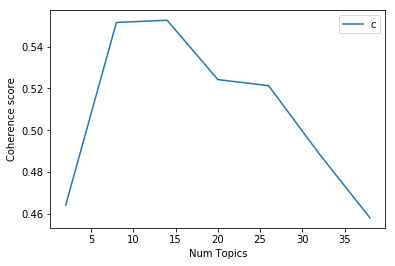

In [40]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4641
Num Topics = 8  has Coherence Value of 0.5516
Num Topics = 14  has Coherence Value of 0.5526
Num Topics = 20  has Coherence Value of 0.5243
Num Topics = 26  has Coherence Value of 0.5213
Num Topics = 32  has Coherence Value of 0.4887
Num Topics = 38  has Coherence Value of 0.4581


In [42]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.048*"position" + 0.038*"section" + 0.031*"piston" + 0.027*"lock" + '
  '0.021*"move" + 0.018*"body" + 0.015*"actuator" + 0.015*"rod" + 0.014*"part" '
  '+ 0.014*"panel"'),
 (1,
  '0.038*"signal" + 0.036*"control" + 0.025*"information" + 0.024*"circuit" + '
  '0.023*"current" + 0.023*"unit" + 0.021*"device" + 0.019*"sensor" + '
  '0.019*"system" + 0.018*"include"'),
 (2,
  '0.050*"control" + 0.036*"value" + 0.027*"speed" + 0.019*"torque" + '
  '0.019*"start" + 0.017*"time" + 0.017*"determine" + 0.017*"state" + '
  '0.015*"step" + 0.014*"amount"'),
 (3,
  '0.047*"model" + 0.042*"utility" + 0.038*"automobile" + 0.020*"disclose" + '
  '0.020*"mg" + 0.018*"car" + 0.016*"structure" + 0.015*"high" + '
  '0.013*"regenerative" + 0.012*"improve"'),
 (4,
  '0.079*"battery" + 0.077*"charge" + 0.074*"power" + 0.059*"electric" + '
  '0.033*"voltage" + 0.026*"module" + 0.026*"supply" + 0.026*"cell" + '
  '0.024*"system" + 0.018*"unit"'),
 (5,
  '0.084*"motor" + 0.064*"drive" + 0.051*"electr

# 4)- Repeat same procedure for TF-IDF model as well

In [44]:
# Compute Perplexity:a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf)) 


Perplexity:  -7.898142302597347


In [45]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6320332731790526


In [46]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [47]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus_tfidf, texts=data_ready, start=2, limit=40, step=6)

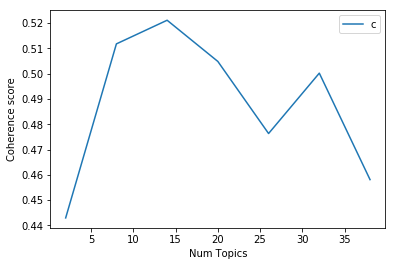

In [48]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [49]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.443
Num Topics = 8  has Coherence Value of 0.5117
Num Topics = 14  has Coherence Value of 0.5211
Num Topics = 20  has Coherence Value of 0.5048
Num Topics = 26  has Coherence Value of 0.4763
Num Topics = 32  has Coherence Value of 0.5002
Num Topics = 38  has Coherence Value of 0.4581


In [50]:
# Select the model and print the topics. We choose 14 so, list[2].
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.081*"mg" + 0.027*"suspension" + 0.027*"acquire" + 0.023*"execution" + '
  '0.017*"master" + 0.016*"connector" + 0.015*"bracket" + 0.014*"cable" + '
  '0.014*"module" + 0.013*"tooth"'),
 (1,
  '0.022*"hydrogen" + 0.019*"fuel" + 0.018*"water" + 0.017*"tank" + '
  '0.017*"cell" + 0.016*"diesel" + 0.014*"oil" + 0.012*"disclosure" + '
  '0.011*"gas" + 0.010*"heat"'),
 (2,
  '0.230*"module" + 0.044*"acquisition" + 0.026*"suppression" + '
  '0.024*"friction" + 0.023*"creep" + 0.019*"resonance" + 0.018*"alternator" + '
  '0.017*"slope" + 0.015*"slow" + 0.015*"traffic"'),
 (3,
  '0.044*"egr" + 0.043*"valve" + 0.023*"intake" + 0.022*"exhaust" + '
  '0.020*"open" + 0.019*"sound" + 0.018*"throttle" + 0.017*"recirculation" + '
  '0.017*"passage" + 0.015*"gas"'),
 (4,
  '0.034*"gear" + 0.026*"shaft" + 0.015*"first" + 0.014*"transmission" + '
  '0.014*"motor" + 0.014*"second" + 0.014*"planetary" + 0.013*"drive" + '
  '0.013*"input" + 0.011*"mechanism"'),
 (5,
  '0.028*"battery" + 0.022*"pow

# 5)- Analysis of LDA model

### 3.1)-the Dominant topic and its percentage contribution in each document

In [67]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus_tfidf, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.4353,"hydrogen, fuel, water, tank, cell, diesel, oil, disclosure, gas, heat","[electrical, energy, system, include, electric, utility, electricity, generation, apparatus, dis..."
1,1,5.0,0.6834,"battery, power, voltage, electric, charge, energy, cell, circuit, system, supply","[electrical, energy, system, include, electric, utility, electricity, generate, apparatus, distr..."
2,2,9.0,0.6159,"catalyst, exhaust, gas, powertrain, fuel, cell, temperature, purification, filter, electrode","[object, provide, particulate, trap, diesel, engine, efficiently, burn, particulate, trap, filte..."
3,3,7.0,0.3142,"body, plate, support, fix, part, lock, member, portion, surface, end","[purpose, obtain, trap, leakage, exhaust, gas, portion, filter, part, surely, prevent, vibration..."
4,4,9.0,0.4365,"catalyst, exhaust, gas, powertrain, fuel, cell, temperature, purification, filter, electrode","[particulate, trap, diesel, engine, design, efficiently, burn, particulate, collect, filter, oxy..."
5,5,9.0,0.6045,"catalyst, exhaust, gas, powertrain, fuel, cell, temperature, purification, filter, electrode","[pct, pct_jp_sec_date, pub, mar, object, provide, particulate, trap, diesel, engine, efficiently..."
6,6,13.0,0.6788,"air, pipe, filter, fuel, cool, oil, inlet, flow, water, chamber","[mix, device, gas, fuel, air, internal, combustion, engine, apt, insert, air, supply, conduit, c..."
7,7,13.0,0.6586,"air, pipe, filter, fuel, cool, oil, inlet, flow, water, chamber","[mix, device, gas, fuel, air, internal, combustion, engine, apt, insert, air, supply, conduit, c..."
8,8,7.0,0.4477,"body, plate, support, fix, part, lock, member, portion, surface, end","[area, mouth, injector, construct, flow, guide, face, twist, tumble, flow, flow, guide, face, fo..."
9,9,13.0,0.5354,"air, pipe, filter, fuel, cool, oil, inlet, flow, water, chamber","[internal, combustion, engine, least, injection, device, cylinder, direct, fuel, injection, comb..."


In [68]:
df_dominant_topic.shape

(68764, 5)

In [69]:
import pickle
df_dominant_topic.to_pickle('top10_topic_dominant.pkl')

In [70]:
print(df_dominant_topic['Text'][2])

['object', 'provide', 'particulate', 'trap', 'diesel', 'engine', 'efficiently', 'burn', 'particulate', 'trap', 'filter', 'supply', 'oxygen', 'natural', 'convection', 'filter', 'regenerate', 'short', 'time', 'minimize', 'power', 'consume', 'heater', 'accomplish', 'purpose', 'end', 'plate', 'bracket', 'weld', 'compress', 'portion', 'inner', 'cylinder', 'outer', 'cylinder', 'heater', 'support', 'ceramic', 'insulator', 'mount', 'spaced', 'heater', 'ambient', 'air', 'introduce', 'passage', 'provide', 'extend', 'case', 'multiple', 'cylinder', 'filter', 'provide', 'case', 'image']


**Compare with original text i.e uncleaned**

'An object is to provide a particulate trap for a diesel engine which can efficiently burn particulates trapped by a filter while supplying oxygen by natural convection so that the filter can be regenerated in a short time while minimizing the power consumed by the heater. To accomplish this purpose, end plates 6, 7 and brackets 9 may be welded to compressed portions 4a, 5a of an inner cylinder 4 and an outer cylinder 5; heater-supporting ceramic insulators are mounted, spaced from each other, on a heater 14; and/or an ambient air introducing passage 36 is provided to extend from outside the case into a multiple-cylinder filter provided in the case.'

## 5.1)-Topic distribution across documents

In [72]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,1.0,"hydrogen, fuel, water, tank, cell, diesel, oil, disclosure, gas, heat",88.0,0.0013
1,5.0,"battery, power, voltage, electric, charge, energy, cell, circuit, system, supply",2873.0,0.0418
2,9.0,"catalyst, exhaust, gas, powertrain, fuel, cell, temperature, purification, filter, electrode",4.0,0.0001
3,7.0,"body, plate, support, fix, part, lock, member, portion, surface, end",424.0,0.0062
4,9.0,"catalyst, exhaust, gas, powertrain, fuel, cell, temperature, purification, filter, electrode",6019.0,0.0875
5,9.0,"catalyst, exhaust, gas, powertrain, fuel, cell, temperature, purification, filter, electrode",7149.0,0.1040
6,13.0,"air, pipe, filter, fuel, cool, oil, inlet, flow, water, chamber",19.0,0.0003
7,13.0,"air, pipe, filter, fuel, cool, oil, inlet, flow, water, chamber",6001.0,0.0873
8,7.0,"body, plate, support, fix, part, lock, member, portion, surface, end",4687.0,0.0682
9,13.0,"air, pipe, filter, fuel, cool, oil, inlet, flow, water, chamber",4082.0,0.0594


### 5.2)-The most representative sentence for each topic

In [55]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9928,"voltage, end, battery, connect, side, body, part, high, first, provide","[present, invention, relate, battery, pack, electric, vehicle, push, part, press, downward, stat..."
1,1.0,0.9920,"speed, control, start, stop, torque, time, rotation, change, combustion, injection","[problem, solve, suppress, execution, rotation, reduction, prevent, control, reduction, target, ..."
2,2.0,0.9930,"motor, drive, first, hybrid, second, torque, control, mode, electric, transmission","[purpose, transmission, hybrid, vehicle, provide, improve, fuel, efficiency, allow, motor, gener..."
3,3.0,0.9947,"combustion, internal, temperature, exhaust, control, gas, fuel, cylinder, device, air","[problem, solve, provide, air, fuel, ratio, control, system, internal, combustion, engine, neces..."
4,4.0,0.9939,"air, fuel, cool, water, cell, valve, flow, intake, heat, inlet","[fuel, filter, system, conditioning, fuel, flow, fuel, supply, mean, internal, combustion, engin..."
5,5.0,0.9942,"fuel, cell, gas, system, hydrogen, filter, diesel, exhaust, include, provide","[invention, relate, blend, blend, membrane, low, po, sub, sub, sub, sub, sub, sub, sub, sub, pol..."
6,6.0,0.9951,"power, electric, charge, battery, control, system, unit, device, supply, energy","[invention, provide, electric, automobile, storage, battery, failure, emergency, control, system..."
7,7.0,0.9924,"value, control, determine, voltage, amount, power, current, time, calculate, battery","[problem, solve, accurately, display, battery, residue, vary, accord, change, state, deteriorati..."
8,8.0,0.9943,"shaft, gear, connect, drive, motor, cylinder, oil, first, second, mechanism","[utility, model, disclose, integrate, drive, transmission, device, electric, automobile, compris..."
9,9.0,0.9947,"pressure, fuel, pump, oil, valve, tank, high, injection, diesel, system","[present, invention, relate, stage, fuel, injection, valve, diesel, engine, comprise, solenoid, ..."


In [58]:
print(sent_topics_sorteddf_mallet['Representative Text'][0])

['present', 'invention', 'relate', 'battery', 'pack', 'electric', 'vehicle', 'push', 'part', 'press', 'downward', 'state', 'structure', 'battery', 'module', 'first', 'housing', 'load', 'second', 'housing', 'push', 'part', 'move', 'downward', 'structure', 'receive', 'second', 'housing', 'push', 'part', 'press', 'downward', 'push', 'part', 'move', 'upward', 'battery', 'module', 'receive', 'second', 'housing', 'separate', 'accord', 'present', 'invention', 'battery', 'pack', 'electric', 'vehicle', 'comprise', 'first', 'housing', 'protrusion', 'part', 'second', 'housing', 'push', 'part', 'cover', 'first', 'housing', 'open', 'upper', 'part', 'allow', 'plurality', 'battery', 'module', 'load', 'interior', 'thereof', 'front', 'rear', 'direction', 'manner', 'space', 'predetermine', 'interval', 'protrusion', 'part', 'form', 'leave', 'side', 'surface', 'first', 'housing', 'second', 'housing', 'allow', 'first', 'housing', 'insert', 'upside', 'push', 'part', 'form', 'position', 'correspond', 'protru

**For our topic model analysis, stop here. We can do this for semantic analysis part.**

### 3.3)-Frequency Distribution of Word Counts in Documents

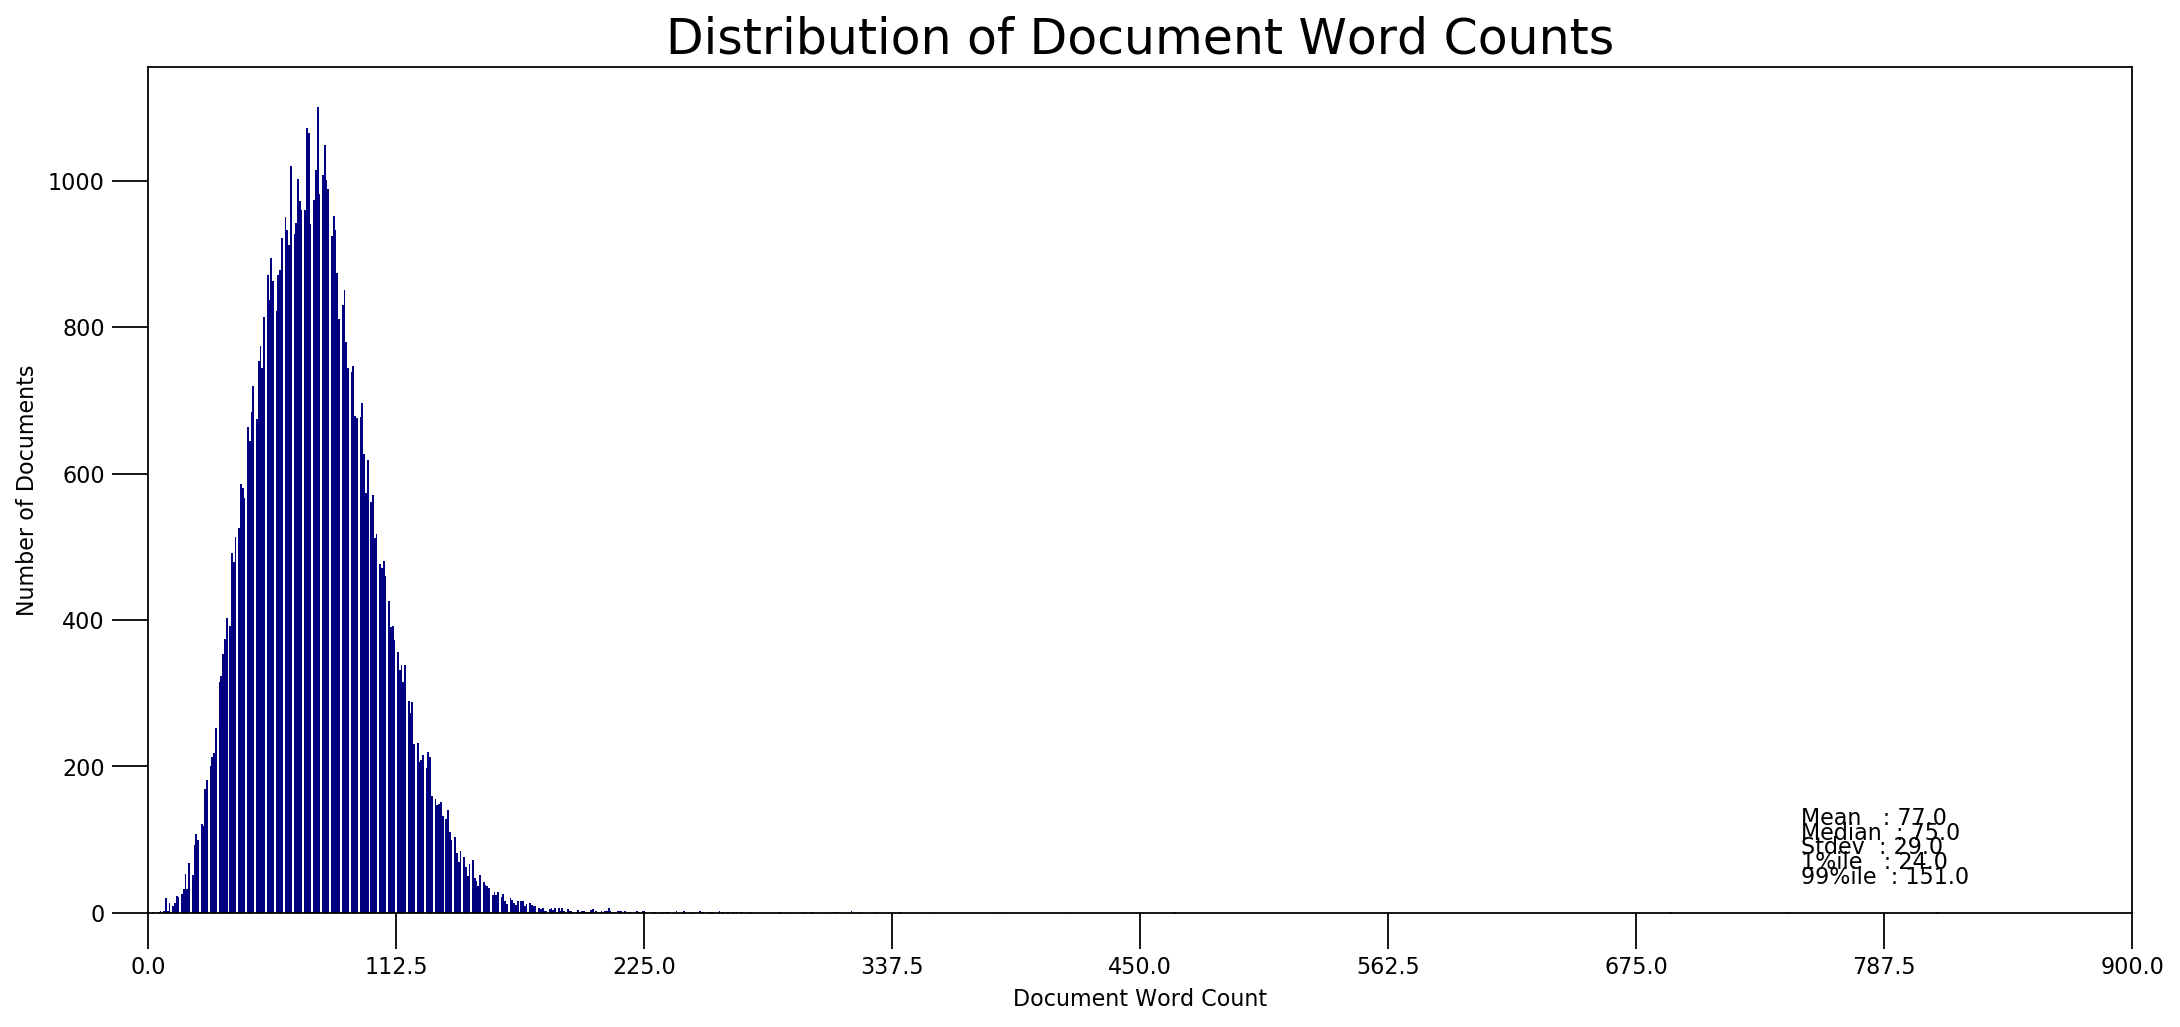

In [59]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 120, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750, 100,"Median  : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev  : " + str(round(np.std(doc_lens))))
plt.text(750,  60, "1%ile   : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  40, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 900), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,900,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

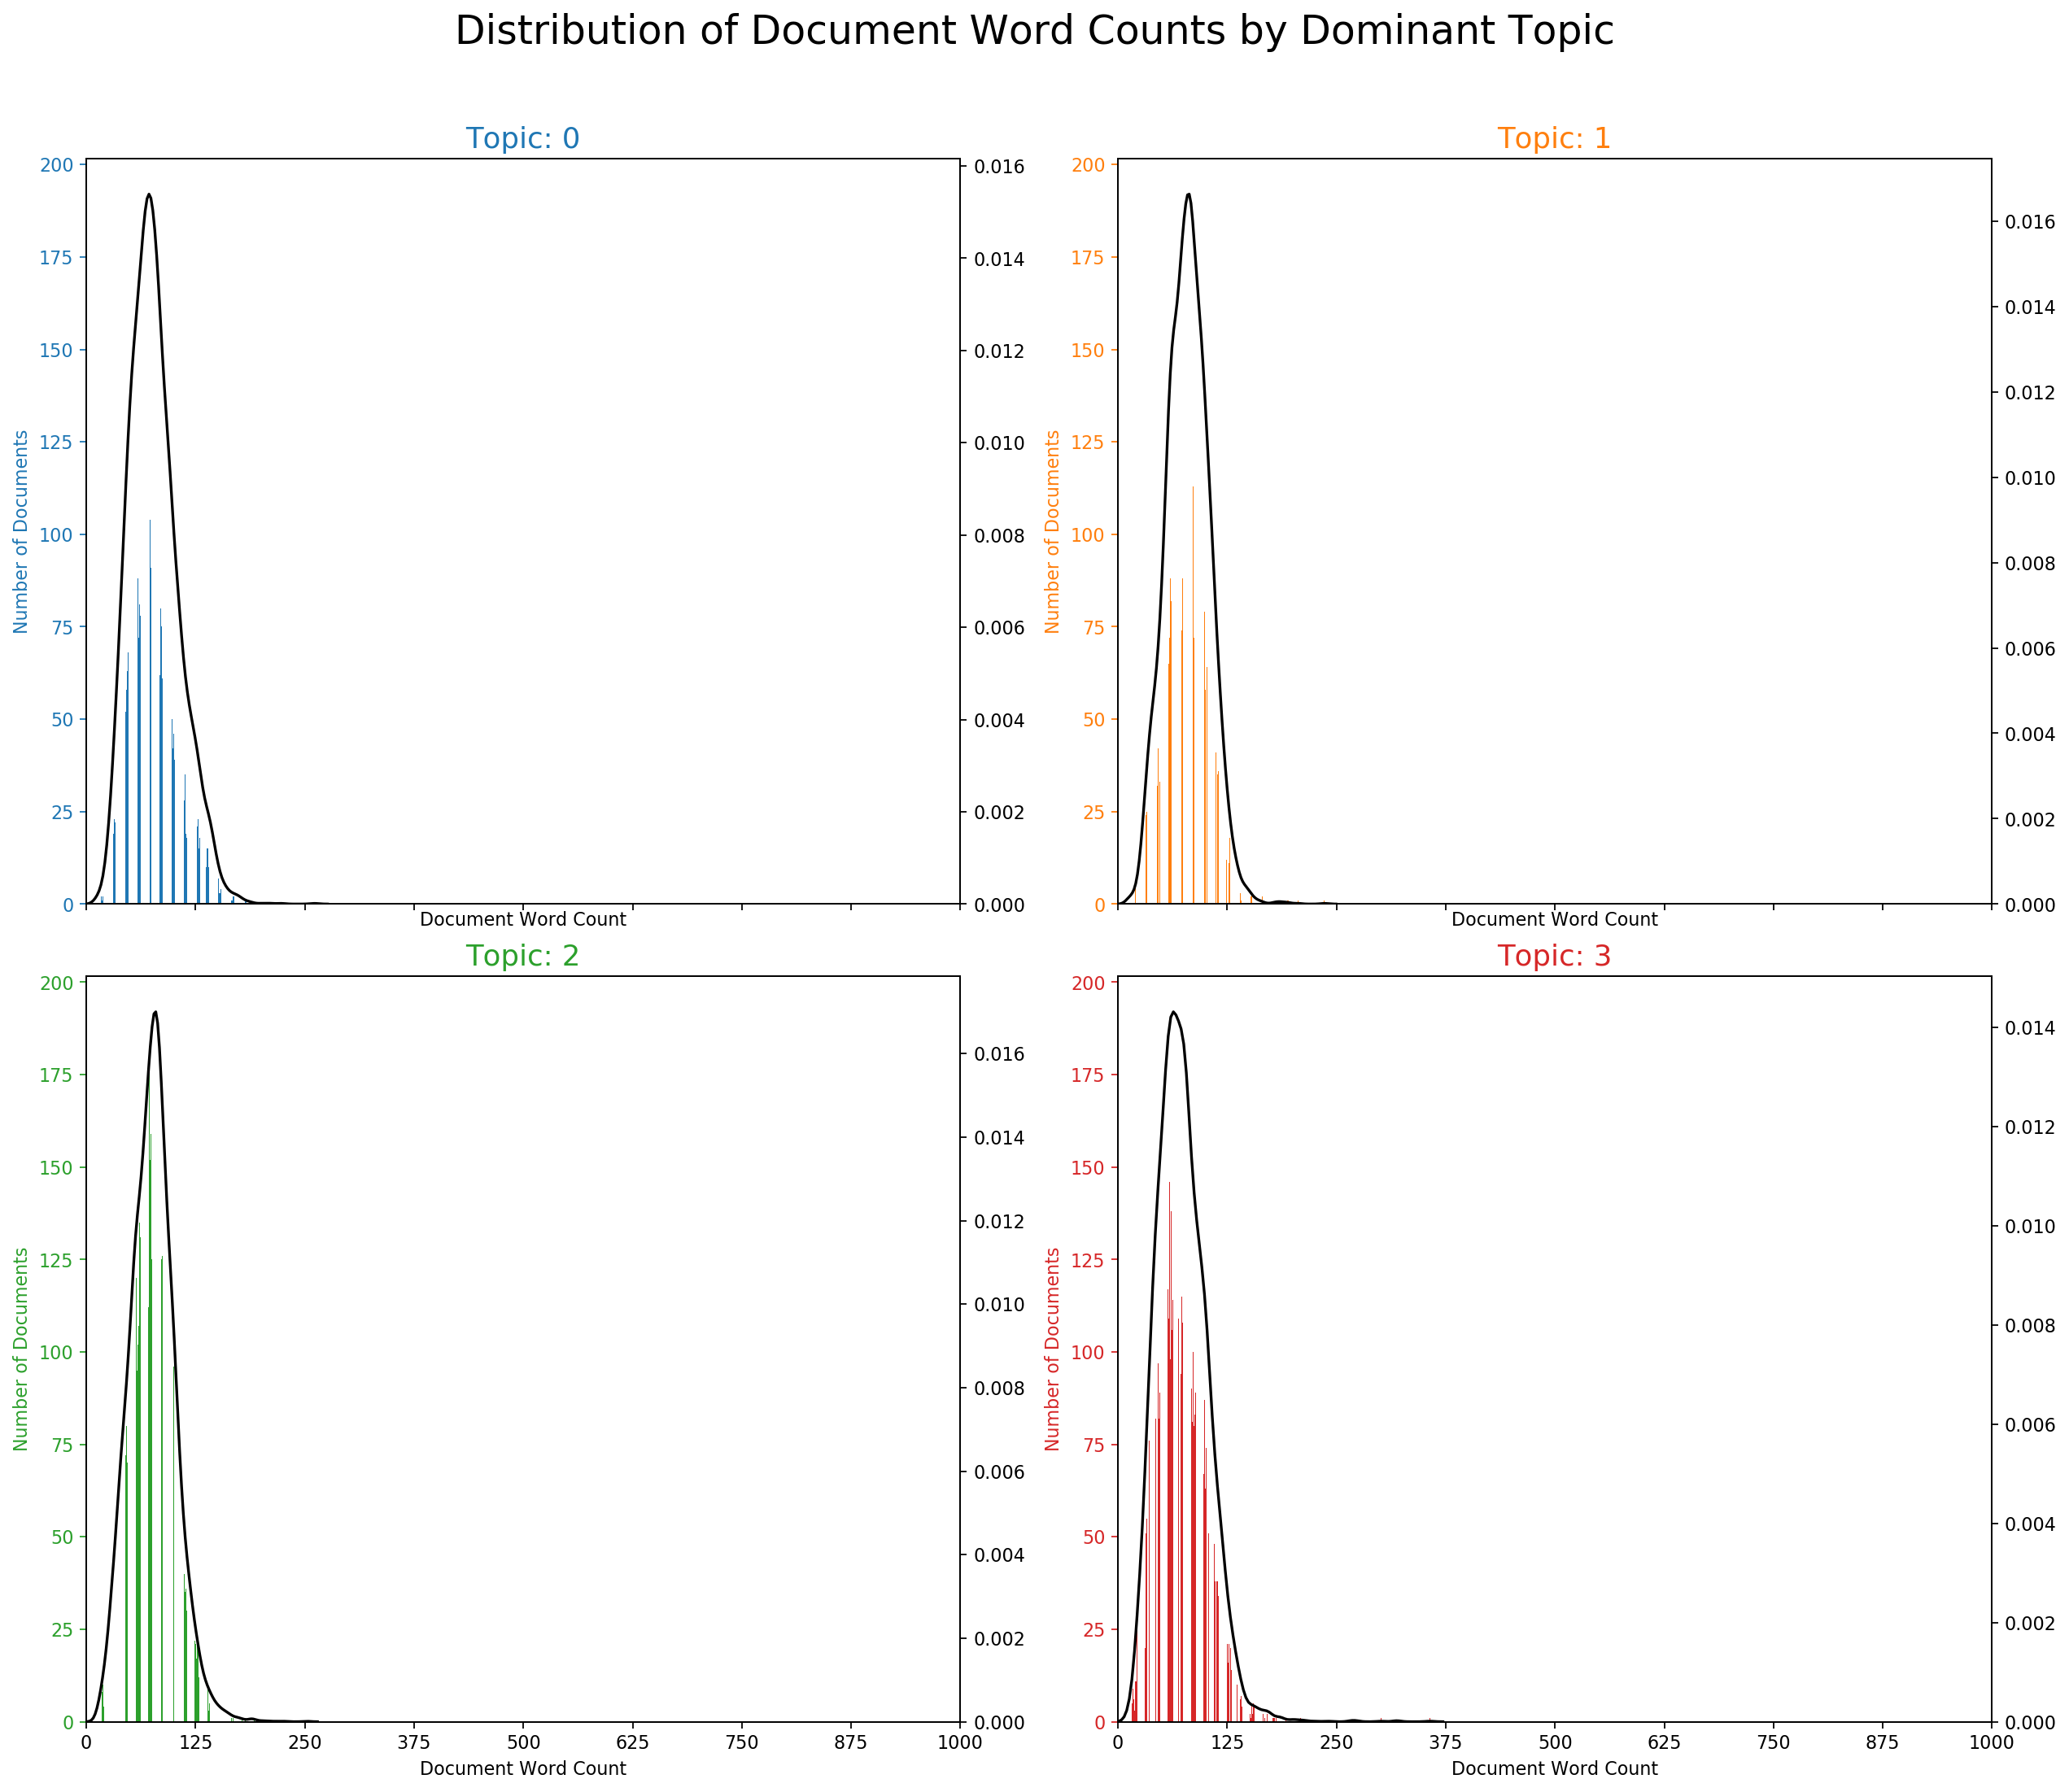

In [60]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### 3.4)-Word Clouds of Top N Keywords in Each Topic

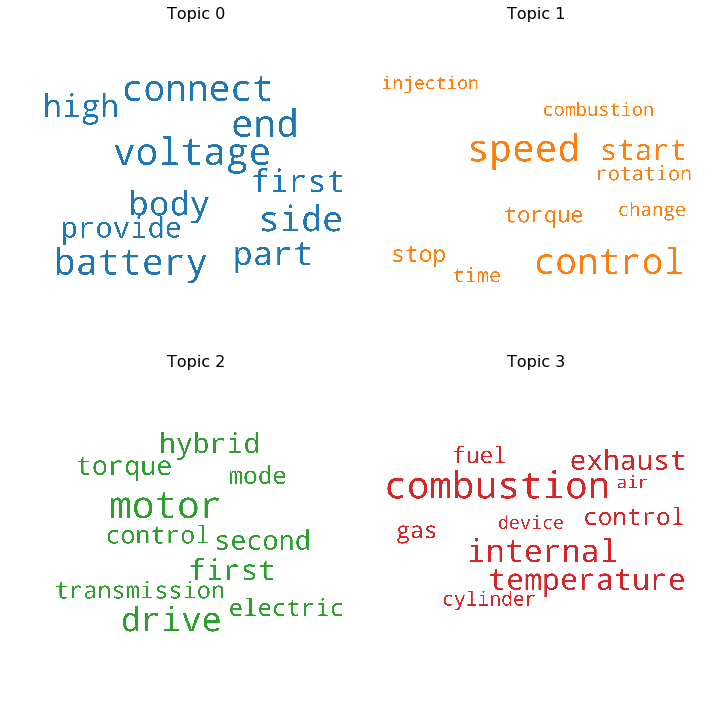

In [61]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 3.5)-Word Counts of Topic Keywords

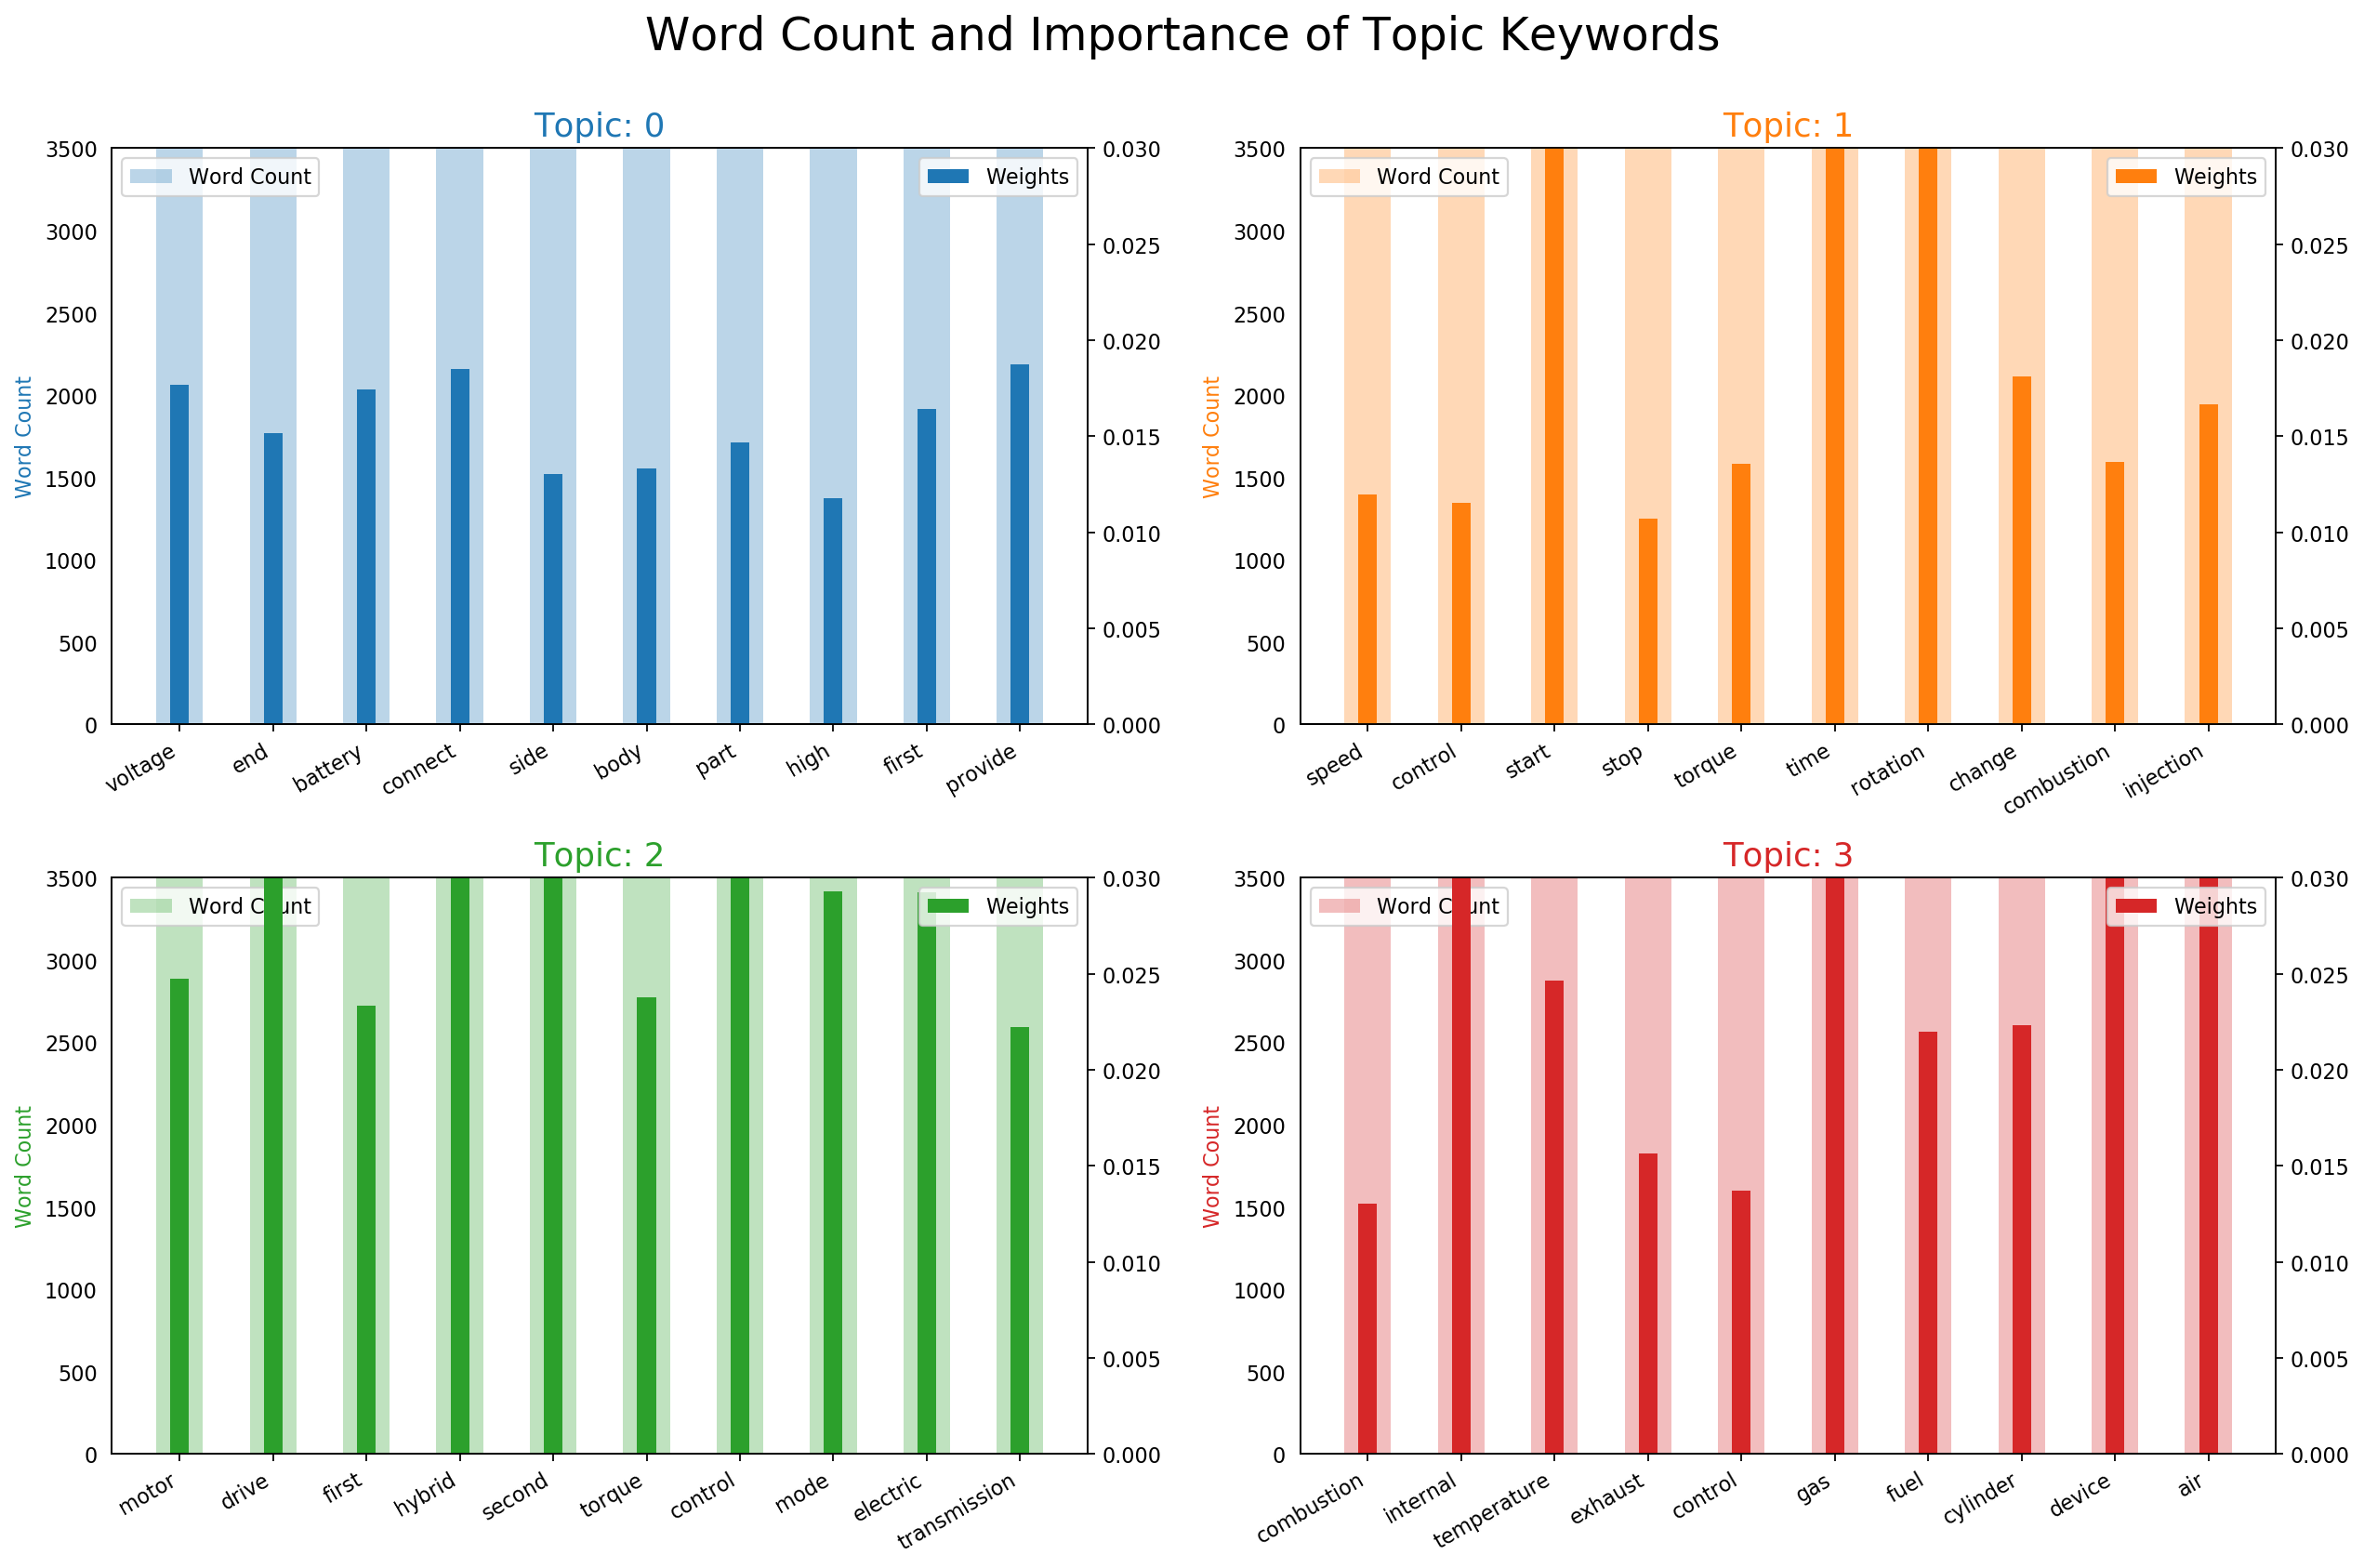

In [62]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### 3.6)-Sentence Chart Colored by Topic

ValueError: too many values to unpack (expected 3)

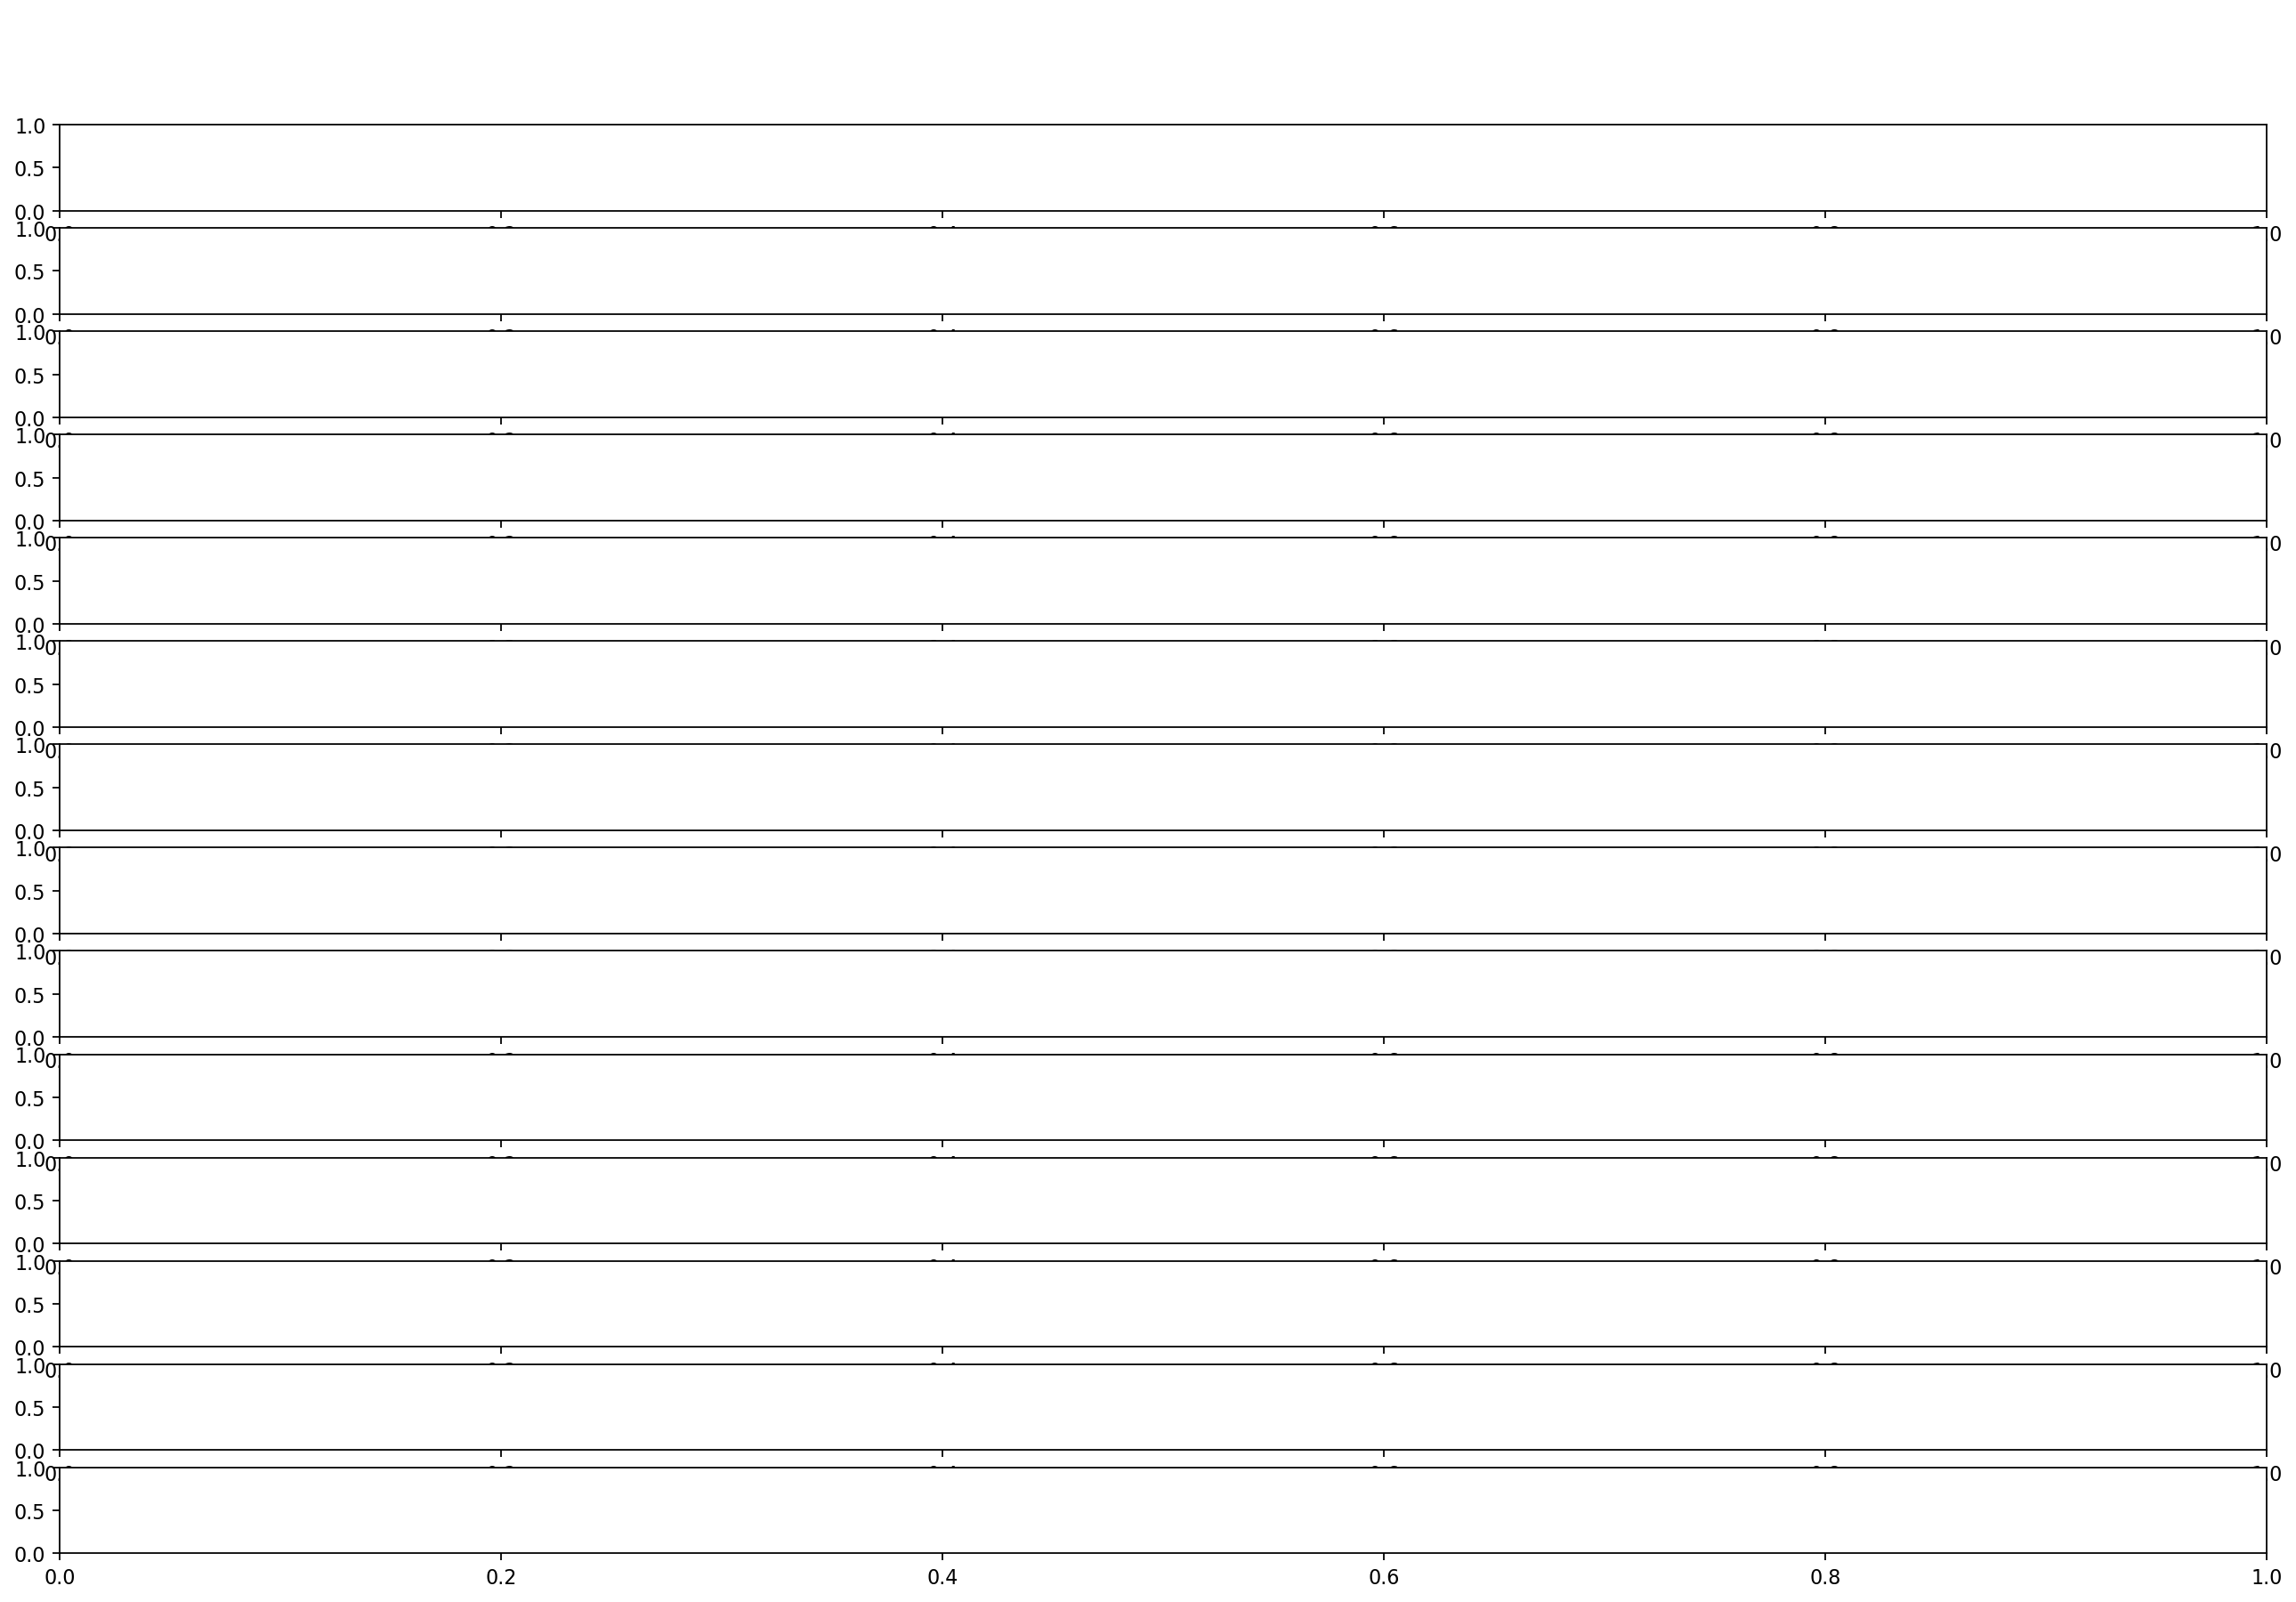

In [63]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 15):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

Colors are given from above shown plot. 

Blue for topic 0, orange for topic 1, green for topic 2 , and red for topic 3.

### 3.7)- The most discussed topics in the documents

In [71]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

ValueError: too many values to unpack (expected 3)

Let’s make two plots:

The number of documents for each topic by assigning the document to the topic that has the most weight in that document.<br>
The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 15000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

# 4)-Visualize topics


### 4.1)- t-SNE Clustering Chart

t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

### 4.2)- pyLDAVis

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis